In [1]:
import numpy as np
import cv2
import open3d as o3d
from matplotlib import pyplot as plt
import time
from scipy.optimize import least_squares
from pylab import *
import scipy
from scipy.sparse import lil_matrix

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def draw_matches(matches, img1, img2, kp1, kp2):
    MIN_MATCH_COUNT = 10
    if len(matches) > MIN_MATCH_COUNT:
        # Estimate homography between template and scene
        src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

        M = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)[0]

        # Draw detected template in scene image
        # h, w = img1.shape
        h = img1.shape[0]
        w = img1.shape[1]
        pts = np.float32([[0, 0],
                          [0, h - 1],
                          [w - 1, h - 1],
                          [w - 1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, M)

        img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

        # h1, w1 = img1.shape
        # h2, w2 = img2.shape
        h1 = img1.shape[0]
        h2 = img2.shape[0]
        w1 = img1.shape[1]
        w2 = img2.shape[1]
        nWidth = w1 + w2
        nHeight = max(h1, h2)
        hdif = int((h2 - h1) / 2)
        newimg = np.zeros((nHeight, nWidth, 3), np.uint8)

        for i in range(3):
            newimg[hdif:hdif + h1, :w1, i] = img1
            newimg[:h2, w1:w1 + w2, i] = img2

        # Draw SIFT keypoint matches
        for m in matches:
            pt1 = (int(kp1[m.queryIdx].pt[0]), int(kp1[m.queryIdx].pt[1] + hdif))
            pt2 = (int(kp2[m.trainIdx].pt[0] + w1), int(kp2[m.trainIdx].pt[1]))
            cv2.line(newimg, pt1, pt2, (255, 0, 0))

        plt.imshow(newimg)
        plt.show()
    else:
        print("Not enough matches are found - %d/%d" % (len(matches), MIN_MATCH_COUNT))


def matching_points(img1, img2):
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    # sift = cv2.SIFT_create()
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    des1 = np.float32(des1)
    des2 = np.float32(des2)
    # Initialize and use FLANN
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    filtered_matches = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            filtered_matches.append(m)

    # kp1=np.float32([kp1[m.queryIdx].pt for m in filtered_matches])
    # kp2=np.float32([kp2[m.trainIdx].pt for m in filtered_matches])
    
    # draw_matches(filtered_matches, img1, img2, kp1, kp2)

    return filtered_matches, kp1, kp2



def find_matches_h(img1, img2):
    ms, kp1, kp2 = matching_points(img1, img2)

    pts1 = np.float32([kp1[m.queryIdx].pt for m in ms])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in ms])
    kps1 = np.hstack((pts1, np.ones((pts1.shape[0], 1)))).astype(np.float32)
    kps2 = np.hstack((pts2, np.ones((pts2.shape[0], 1)))).astype(np.float32)
    return kps1, kps2


def find_matches(img1, img2):
    kps1, kps2 = find_matches_h(img1, img2)
    kp1 = kps1[:, 0:2]
    kp2 = kps2[:, 0:2]
    return kp1, kp2, kps1, kps2


In [3]:
def triangulation(proj_ref, proj_next, kp1, kp2):
    kp1 = kp1.T
    kp2 = kp2.T
    cloud = cv2.triangulatePoints(proj_ref, proj_next, kp1, kp2)
    cloud /= cloud[3]

    return kp1, kp2, cloud


# Returns points that were common in the 3 images and a set of points that were not common
def three_view_points(kp2, kp2_dash, kp3):
    # Kp2 is the set of keypoints obtained from image(n-1) and image(n)
    # kp2_dash and kp3 are the set of keypoints obtained from image(n) and image(n+1)

    # Find the indices of the common keypoints in the three images by comparing kp2 and kp2_dash
    index1 = []
    index2 = []
    for i in range(kp2.shape[0]):
        if (kp2[i, :] == kp2_dash).any():
            index1.append(i)
        x = np.where(kp2_dash == kp2[i, :])
        if x[0].size != 0:
            index2.append(x[0][0])

    # We also need to find out the keypoints that were not common
    kp3_uncommon = []
    kp2_dash_uncommon = []

    for k in range(kp3.shape[0]):
        if k not in index2:
            kp3_uncommon.append(list(kp3[k, :]))
            kp2_dash_uncommon.append(list(kp2_dash[k, :]))

    index1 = np.array(index1)
    index2 = np.array(index2)
    kp2_dash_common = kp2_dash[index2]
    kp3_common = kp3[index2]

    return index1, kp2_dash_common, kp3_common, np.array(kp2_dash_uncommon), np.array(kp3_uncommon)


def perspective_n_point(cloud, kp1, kp2, K):
    diss_coeff = np.zeros((5, 1))

    _, rot, trans, inliers = cv2.solvePnPRansac(cloud, kp1, K, diss_coeff, cv2.SOLVEPNP_ITERATIVE)
    if inliers is None:
        print("inliers none")
        return [], [], [], [], [], []

    inliers = inliers[:, 0]
    rot, _ = cv2.Rodrigues(rot)

    return rot, trans, kp2[inliers], cloud[inliers], kp1[inliers], inliers

In [4]:
# Function to calculate the error in keypoint locations by reprojecting the 3d point cloud on the image plane
def reprojection_error(cloud, kp, trans_mat, K):
    rot, _ = cv2.Rodrigues(trans_mat[:3, :3])

    kp_reprojected, _ = cv2.projectPoints(cloud, rot, trans_mat[:3, 3], K, distCoeffs=None)
    kp_reprojected = np.float32(kp_reprojected[:, 0, :])

    error = cv2.norm(kp_reprojected, kp, cv2.NORM_L2)

    return error / len(kp_reprojected), kp_reprojected



def algebraic_error(keypoints1, keypoints2, F):
    errors = []
    for kp1, kp2 in zip(keypoints1, keypoints2):
        error = np.abs(kp1[None, ...] @ F @ kp2[None, ...].T)
        errors.append(error.item())
    return errors


def geometric_error(keypoints1, keypoints2, F):
    errors = []
    for kp1, kp2 in zip(keypoints1, keypoints2):
        x1F = kp1[None, ...] @ F
        Fx2 = F @ kp2[None, ...].T
        x1Fx2 = x1F @ kp2[None, ...].T

        part1 = 1 / (x1F.flatten()[0] ** 2 + x1F.flatten()[1] ** 2)
        part2 = 1 / (Fx2.flatten()[0] ** 2 + Fx2.flatten()[1] ** 2)

        error = np.sqrt(x1Fx2 ** 2 * (part1 + part2))
        errors.append(error.item())
    return errors

In [5]:
def find_fundamental_svd(kps1, kps2):
    """
    Estimate fundamental matrix using SVD
    :param kps1: keypoints extracted from view1 in homogeneous coordinates
    :param kps2: keypoints extracted from view2 in homogeneous coordinates
    """
    # condition points
    assert len(kps1) == len(kps2)
    m = len(kps1)
    s1 = np.max(np.sqrt(np.sum(np.square(kps1), axis=1)))
    t1 = np.mean(kps1, axis=0)
    T1 = np.array([[1 / s1, 0, -t1[0] / s1],
                   [0, 1 / s1, -t1[1] / s1],
                   [0, 0, 1]])
    x1 = np.ones((3, m))
    x1[:2, :] = kps1.T
    x_hat1 = np.dot(T1, x1)

    s2 = np.max(np.sqrt(np.sum(np.square(kps2), axis=1)))
    t2 = np.mean(kps2, axis=0)
    T2 = np.array([[1 / s2, 0, -t2[0] / s2],
                   [0, 1 / s2, -t2[1] / s2],
                   [0, 0, 1]])
    x2 = np.ones((3, m))
    x2[:2, :] = kps2.T
    x_hat2 = np.dot(T2, x2)

    # collect equations
    A = np.zeros((m, 9))
    # img1 x' y' x y im2
    for i in range(m):
        A[i] = [x_hat1[0, i] * x_hat2[0, i], x_hat1[0, i] * x_hat2[1, i], x_hat1[0, i],
                x_hat1[1, i] * x_hat2[0, i], x_hat1[1, i] * x_hat2[1, i], x_hat1[1, i],
                x_hat2[0, i], x_hat2[1, i], 1.0]

    # solve for fundamental matrix using SVD
    U, S, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)

    # uncondition F
    F = np.dot(T1.T, np.dot(F, T2))

    # make rank 2
    U, S, V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U, np.dot(np.diag(S), V))
    F = F / F[2, 2]

    return F


def find_fundamental_ransac(keypoints1, keypoints2, num_samples=8, threshold=0.01, iterations=1000, min_inliers=30):
    """
    Optimizes fundamental matrix parameters using RANSAC algorithm
    :params keypoints1: the key points from view 1 matching
                        with the key points from view 2
                        --> they are expected to be in homogenous coordinates
    :params keypoints2: the key points from view 2 matching
                        with the key points from view 1
                        --> they are expected to be in homogenous coordinates
    :param num_samples: the number of samples to draw in each iteration
    :param threshold: determines the error value at which we decide for inlier or outlier
    :iterations: maximum number of iterations
    :returns: fundamental matrix and a binary mask indicating the inlier points in keypoints1 and keypoints2

    """
    assert len(keypoints1) == len(keypoints2)
    N = len(keypoints1)
    inlier_mask = np.zeros(N)
    avg_err = 100000
    for i in range(iterations):
        shuffle_id = np.random.permutation(N)
        kp1 = keypoints1[shuffle_id]
        kp2 = keypoints2[shuffle_id]

        F_i = find_fundamental_svd(kp1[:num_samples], kp2[:num_samples])

        hkp1 = np.ones((N, 3))
        hkp1[:, :2] = keypoints1
        hkp2 = np.ones((N, 3))
        hkp2[:, :2] = keypoints2

        error1 = algebraic_error(hkp1, hkp2, F_i)
        error2 = geometric_error(hkp1, hkp2, F_i)
        error2 = np.array(error2)
        inlier_mask_i = error2 < threshold
        if np.mean(error2[inlier_mask_i]) < avg_err and np.sum(inlier_mask_i.astype(np.uint8)) >= min_inliers:
            F = F_i
            inlier_mask = inlier_mask_i
            avg_err = np.mean(error2[inlier_mask_i])

    return F, inlier_mask


def visualize_epipolar_lines(img1, img2, keypoints1, keypoints2, F):
    fig, axes = plt.subplots(1,2,figsize=(16,7))

    # draw images
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    res = img1.shape[:2]

    for color_index, (kp1, kp2) in enumerate(zip(keypoints1, keypoints2)):
        c = np.random.rand(3)

        # plot points
        axes[0].plot(kp1[0], kp1[1], color=c, marker='o',markersize=5)
        axes[1].plot(kp2[0], kp2[1], color=c, marker='o',markersize=5)

        # compute epi lines
        epi_line_2 = kp1[None,...] @ F
        epi_line_1 = F @ kp2[None,...].T

        # plot lines
        for i, line in enumerate([epi_line_1, epi_line_2]):
            line = line.flatten()
            fn = lambda x: (line[0]*x + line[2]) / -line[1]
            xs = np.arange(res[1])
            axes[i].plot(xs, fn(xs), c=c)

    axes[0].set_ylim((res[0],0))
    axes[1].set_ylim((res[0],0))

    plt.show()

In [6]:
def normalize_norm(A):
    return A / scipy.linalg.norm(A)


def stabilize(x, tol = 1e-6):
    xs = x.copy()
    xs[abs(xs) < tol] = 0
    return xs


def self_calibrate(F, w, h):
    # Compute the semi-calibrated fundamental matrix
    K = array([[2 * (w + h), 0, w / 2], [0, 2 * (w + h), h / 2], [0, 0, 1]])
    G = normalize_norm(dot(K.T, dot(F, K)))

    # Self-calibration using the Kruppa equations (Sturm's method)
    U, s, Vh = svd(G)
    fp = array(
        [s[0] ** 2 * (1 - U[2, 0] ** 2) * (1 - Vh[0, 2] ** 2) - s[1] ** 2 * (1 - U[2, 1] ** 2) * (1 - Vh[1, 2] ** 2),
         s[0] ** 2 * (U[2, 0] ** 2 + Vh[0, 2] ** 2 - 2 * U[2, 0] ** 2 * Vh[0, 2] ** 2) - s[1] ** 2 * (
                     U[2, 1] ** 2 + Vh[1, 2] ** 2 - 2 * U[2, 1] ** 2 * Vh[1, 2] ** 2),
         s[0] ** 2 * U[2, 0] ** 2 * Vh[0, 2] ** 2 - s[1] ** 2 * U[2, 1] ** 2 * Vh[1, 2] ** 2])

    rs = roots(fp)
    rs = real(rs[abs(imag(rs)) < 1e-6])
    rs = rs[rs > 0]

    f = 2 * (w + h)
    if any(abs(fp) > 1e-6) and len(rs) > 0:
        f = 2 * (w + h) * sqrt(rs[0])

    K = array([[f, 0, w / 2], [0, f, h / 2], [0, 0, 1]])
    E = dot(K.T, dot(F, K))  # E = K.T * F * K
    return stabilize(normalize_norm(E)), K

In [7]:
# Function returns a downsampled image
def subsample(image, down_sample):
    down_sample = down_sample / 2
    i = 0

    while (i < down_sample):
        image = cv2.pyrDown(image)
        i += 1

    return image


K_init = np.array([[2393.952166119461, -3.410605131648481e-13, 932.3821770809047],
                   [0, 2398.118540286656, 628.2649953288065],
                   [0, 0, 1]])

down_sample=2.0
K_init[0,0] = K_init[0,0]/down_sample
K_init[1,1] = K_init[1,1]/down_sample
K_init[0,2] = K_init[0,2]/down_sample
K_init[1,2] = K_init[1,2]/down_sample

def estimate_cloud(F, w, h, kp1, kp2, calibrated):
    if calibrated:
        K = K_init
        E, mask = cv2.findEssentialMat(kp1, kp2, K, method=cv2.RANSAC, prob=0.999, threshold=0.4, mask=None)
        kp1 = kp1[mask.ravel() == 1]
        kp2 = kp2[mask.ravel() == 1]
    else:
        E, K = self_calibrate(F, w, h)

    _, rot, trans, mask = cv2.recoverPose(E, kp1, kp2, K)
    initial = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
    M1 = np.matmul(K, initial)
    trans = trans.ravel()
    trans_12 = np.empty((3, 4))
    trans_12[:3, :3] = np.matmul(rot, initial[:3, :3])
    trans_12[:3, 3] = initial[:3, 3] + np.matmul(initial[:3, :3], trans)
    M2 = np.matmul(K, trans_12)
    cloud = cv2.triangulatePoints(M1, M2, kp1.T, kp2.T)
    return cloud, M1, M2, K, kp1, kp2



def estimate_base_cloud(img1, img2, calibrated=False, customized_ransac=False):
    w = []
    h = []
    F = []
    if calibrated:
        kp1, kp2, kps1, kps2 = find_matches(img1, img2)
    else:
        kp1, kp2, kps1, kps2 = find_matches(img1, img2)
        if customized_ransac:
            # use Ma Xianghe version find_fundamental_ransac
            F, mask = find_fundamental_ransac(kp1, kp2, num_samples=16, threshold=2, iterations=2000, min_inliers=88)
            kp1 = kp1[mask.ravel() == 1]
            kp2 = kp2[mask.ravel() == 1]
            kps1 = kps1[mask.ravel() == 1]
            kps2 = kps2[mask.ravel() == 1]
        else:
            # use opencv findFundamentalMat cv2.FM_RANSAC
            F, mask = cv2.findFundamentalMat(kps1, kps2, cv2.FM_RANSAC)
            kps1 = kps1[mask.ravel() == 1]
            kps2 = kps2[mask.ravel() == 1]
            kp1 = kps1[:, 0:2]
            kp2 = kps2[:, 0:2]
        view1 = np.array(img1) / 255
        view2 = np.array(img2) / 255
        # visualize_epipolar_lines(view1, view2, kps1, kps2, F)

        w = img1.shape[0]
        h = img1.shape[1]

    cloud, M1, M2, K, kp1, kp2 = estimate_cloud(F, w, h, kp1, kp2, calibrated)
    cloud /= cloud[3]
    cloud = cv2.convertPointsFromHomogeneous(cloud.T)

    return cloud, kp1, kp2, M1, M2, K

In [8]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """
    Compute residuals.
    `params` contains camera parameters and 3-D coordinates.
    """
    camera_params = params[:n_cameras * 12].reshape((n_cameras, 3, 4))
    points_3d = params[n_cameras * 12:].reshape((n_points, 3))
    points_3d_h = np.hstack([points_3d, np.ones((n_points, 1))])

    points_proj = np.zeros(points_2d.shape)
    for i in range(points_2d.shape[0]):
        M = camera_params[camera_indices[i]]
        P = points_3d_h[point_indices[i]]
        point = np.dot(M, P)
        point /= point[2]
        points_proj[i] = point[0:2]
    return (points_proj - points_2d).ravel()


def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    """
    To make this process time feasible we provide Jacobian sparsity structure
    (i. e. mark elements which are known to be non-zero):
    """
    m = camera_indices.size * 2
    n = n_cameras * 12 + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(12):
        A[2 * i, camera_indices * 12 + s] = 1
        A[2 * i + 1, camera_indices * 12 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 12 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 12 + point_indices * 3 + s] = 1

    return A


def bundel_adjustemt_2view(cloud, M1, M2, kp1, kp2):
    cameras_params = np.hstack([M1.ravel(), M2.ravel()])
    points_params = cloud.ravel()
    params = np.hstack([cameras_params.ravel(), points_params.ravel()])
    n_cameras = 2
    n_points = cloud.shape[0]
    points_2d = np.vstack([kp1, kp2])
    camera_indices = np.zeros(points_2d.shape[0], dtype=np.int)
    point_indices = np.arange(0, points_2d.shape[0], dtype=np.int)
    camera_indices[n_points:] = 1
    point_indices[n_points:] = np.arange(0, n_points)
    f0 = fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d)
    plt.plot(f0)

    A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
    t0 = time.time()
    x0 = params
    res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                        args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
    t1 = time.time()
    print("Optimization took {0:.0f} seconds".format(t1 - t0))
    print(res.x)
    print(params.shape)
    print(res.x.shape)
    plt.plot(res.fun)
    plt.show()

    M1 = res.x[0:12].reshape((3, 4))
    M2 = res.x[12:24].reshape((3, 4))
    cloud = res.x[n_cameras * 12:].reshape((n_points, 3))

    return cloud, M1, M2


In [9]:
class BACollection:
    def __init__(self, clouds, M1, M2, kp1, kp2):
        p_matrices = np.vstack([M1.reshape(1, 3, 4), M2.reshape(1, 3, 4)])
        key_points = np.vstack([kp1, kp2])
        camera_indices = np.hstack([np.zeros(kp1.shape[0]), np.ones(kp2.shape[0])]).ravel()
        point_indices = np.hstack([np.arange(0, kp1.shape[0], 1), np.arange(0, kp2.shape[0], 1)]).ravel()
        self.clouds = clouds
        self.p_matrices = p_matrices
        self.key_points = key_points
        self.camera_indices = camera_indices.astype(np.int32)
        self.point_indices = point_indices.astype(np.int32)

    def extend_matrices_with_points(self, M, kp, point_indices, cloud_ref):
        self.p_matrices = np.vstack([self.p_matrices, M.reshape(1, 3, 4)])
        self.key_points = np.vstack([self.key_points, kp])
        indices = np.ones(kp.shape[0], dtype=np.int32)*(self.p_matrices.shape[0]-1)
        self.camera_indices = np.hstack([self.camera_indices, indices]).ravel()
        point_indices = point_indices + (self.clouds.shape[0] - cloud_ref.shape[0])
        self.point_indices = np.hstack([self.point_indices, point_indices])

    def add_points(self, clouds, kp1, kp2):
        self.clouds = np.vstack([self.clouds, clouds])
        self.key_points = np.vstack([self.key_points, kp1, kp2])
        camera_indices01 = np.zeros(kp1.shape[0], dtype=np.int32) + self.p_matrices.shape[0] - 2
        camera_indices02 = np.zeros(kp1.shape[0], dtype=np.int32) + self.p_matrices.shape[0] - 1
        self.camera_indices = np.hstack([self.camera_indices, camera_indices01, camera_indices02]).ravel()
        point_indices01 = np.arange(self.clouds.shape[0] - clouds.shape[0], self.clouds.shape[0], 1)
        point_indices02 = point_indices01
        self.point_indices = np.hstack([self.point_indices, point_indices01, point_indices02]).ravel()
        
        
def bundel_adjustemt_multiview(clouds, p_matrices, key_points, camera_indices, point_indices):
    n_cameras = p_matrices.shape[0]
    n_points = clouds.shape[0]
    A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)

    cameras_params = p_matrices.ravel()
    points_params = clouds.ravel()
    params = np.hstack([cameras_params.ravel(), points_params.ravel()])
    x0 = params
    f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, key_points)
    plt.plot(f0)

    t0 = time.time()
    res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e2, method='trf',
                        args=(n_cameras, n_points, camera_indices, point_indices, key_points))
    t1 = time.time()
    print("Optimization took {0:.0f} seconds".format(t1 - t0))
    plt.plot(res.fun)
    plt.show()

    clouds = res.x[n_cameras * 12:].reshape((n_points, 3))

    return clouds

In [10]:
def generalize_color(img, x, y):
    # color_sum = np.zeros(3)
    # count = 0
    # a = x - 2 if x - 2 >= 0 else 0
    # b = x + 2 if x + 2 < img.shape[0] else img.shape[0]
    # c = y - 2 if y - 2 >= 0 else 0
    # d = y + 2 if y + 2 < img.shape[1] else img.shape[1]
    # for i in range(a, b):
    #     for j in range(c, d):
    #         color_sum += img[i,j]
    #         count += 1
    # color = color_sum/count

    return img[x, y]

def output(final_cloud, pixel_colour, filename='sparse.ply'):
    output_points = final_cloud.reshape(-1, 3) * 200
    output_colors = pixel_colour.reshape(-1, 3)
    mesh = np.hstack([output_points, output_colors])

    mesh_mean = np.mean(mesh[:, :3], axis=0)
    diff = mesh[:, :3] - mesh_mean
    distance = np.sqrt(diff[:, 0] ** 2 + diff[:, 1] ** 2 + diff[:, 2] ** 2)

    index = np.where(distance < np.mean(distance) + 300)
    mesh = mesh[index]
    ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar blue
        property uchar green
        property uchar red
        end_header
        '''
    with open(filename, 'w') as f:
        f.write(ply_header % dict(vert_num=len(mesh)))
        np.savetxt(f, mesh, '%f %f %f %d %d %d')
    print("Point cloud processed, cleaned and saved successfully!")

In [11]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    visualization_pcds([inlier_cloud, outlier_cloud], point_size=3)

    # o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
    #                                   zoom=0.3412,
    #                                   front=[0.4257, -0.2125, -0.8795],
    #                                   lookat=[2.6172, 2.0475, 1.532],
    #                                   up=[-0.0694, -0.9768, 0.2024])


def visualization_pcds(pcds, point_size=2):
    vis = o3d.visualization.Visualizer()
    vis.create_window()

    render_option = vis.get_render_option()
    render_option.background_color = np.array([1, 1, 1])  # set background white
    render_option.point_size = point_size  # set point size
    for pcd in pcds:
        vis.add_geometry(pcd)
    vc = vis.get_view_control()
    vc.set_up([-0.0694, -0.9768, 0.2024])

    vis.run()
    vis.destroy_window()


def visualization_pcd(pcd):
    visualization_pcds([pcd])


def visualization(cloud_filename='sparse.ply', surface_reconstruction=False):
    pcd = o3d.io.read_point_cloud(cloud_filename)
    visualization_pcd(pcd)

    print("Statistical oulier removal")
    cl, ind = pcd.remove_statistical_outlier(nb_neighbors=400, std_ratio=1.0)
    display_inlier_outlier(pcd, ind)
    pcd = pcd.select_by_index(ind)
    visualization_pcd(pcd)
    #     o3d.visualization.draw_geometries([pcd])

    if not surface_reconstruction:
        return

    # This algorithm assumes that the PointCloud has normals. Require enough Cloud Points and with normals.
    # estimate_normals() can provide estimated normals, usually not sufficient
    print('run Poisson surface reconstruction')
    pcd.estimate_normals()
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd, depth=9)
    print(mesh)
    o3d.visualization.draw_geometries([mesh],
                                      zoom=0.664,
                                      front=[-0.4761, -0.4698, -0.7434],
                                      lookat=[1.8900, 3.2596, 0.9284],
                                      up=[0.2304, -0.8825, 0.4101])


In [12]:
def run_3d_reconstruction_sfm(calibrated=False, customized_ransac=False, cloud_filename='sparse.ply'):
    images = []
    images_gray = []
    final_cloud = np.zeros((1, 3))
    pixel_colour = np.array([130, 0, 0]) # red

    # Acquiring dataset
    for i in range(351, 408):
        image = cv2.imread("sfm_dataset/DSC_0" + str(i) + ".JPG")
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)
        images_gray.append(image_gray)

    img1 = subsample(images[0], down_sample)
    img2 = subsample(images[1], down_sample)

    cloud_ref, kp1, kp2, M1, M2, K = estimate_base_cloud(img1, img2, calibrated, customized_ransac)
    cloud_ref = cloud_ref[:, 0, :]
    if not calibrated:
        cloud_ref, M1, M2 = bundel_adjustemt_2view(cloud_ref, M1, M2, kp1, kp2)

    final_cloud = np.vstack((final_cloud, cloud_ref))
    kps = np.array(kp2, dtype=np.int32)
    colors = np.array([img2[kp[1], kp[0]] for kp in kps])
    pixel_colour = np.vstack((pixel_colour, colors))

    bac = BACollection(cloud_ref, M1, M2, kp1, kp2)

    for i in range(2, len(images)): 
        if i > 2:
            # Set the reference
            kp1, kp2, cloud = triangulation(M1, M2, kp1, kp2)
            kp1 = kp1.T
            kp2 = kp2.T
            cloud = cv2.convertPointsFromHomogeneous(cloud.T)
            cloud_ref = cloud[:, 0, :]

        # new_img = images_gray[i]
        new_img = subsample(images[i], down_sample)
        nkp2, nkp3, kps2, kps3 = find_matches(img2, new_img)
        index, nkp2_common, nkp3_common, nkp2_uncommon, nkp3_uncommon = three_view_points(kp2, nkp2, nkp3)

        if nkp3_common.shape[0] <= 4:  # perspective_n_point need at least 4 pionts
            print("nkp3_common <= 4")
            continue

        rot, trans, nkp3_common, cloud_pnp, nkp2_common, inliers =\
            perspective_n_point(cloud_ref[index], nkp3_common, nkp2_common, K)
        inliers_index = index[inliers]

        if len(cloud_pnp) == 0:  # if pnp failed and find zero clouds
            print("cloud none")
            continue

        trans_mat_new = np.hstack((rot, trans))
        M_new = np.matmul(K, trans_mat_new)

        _, _, cloud = triangulation(M2, M_new, nkp2_uncommon, nkp3_uncommon)
        cloud = cv2.convertPointsFromHomogeneous(cloud.T)

        error1, kp_projected = reprojection_error(cloud_pnp, nkp3_common, trans_mat_new, K)
        error2, kp_reprojected = reprojection_error(cloud, nkp3_uncommon, trans_mat_new, K)
        # Total reprojection error
        print("Reprojection Error after " + str(i) + " images:" + str(np.round(error1 + error2, 4)))

        final_cloud = np.vstack((final_cloud, cloud[:, 0, :]))
        ikp = np.array(nkp3_uncommon, dtype=np.int32)
        colors = np.array([generalize_color(new_img, kp[1], kp[0]) for kp in ikp])
        pixel_colour = np.vstack((pixel_colour, colors))


        bac.extend_matrices_with_points(M_new, nkp3_common, inliers_index, cloud_ref)
        bac.add_points(cloud[:, 0, :], nkp2_uncommon, nkp3_uncommon)

        M1 = M2
        M2 = M_new
        img2 = new_img
        kp1 = nkp2
        kp2 = nkp3

    output(final_cloud, pixel_colour, cloud_filename)
    
    return bac



In [13]:
%%javascript
//IPython.OutputArea.auto_scroll_threshold = 9999;   //setting threshold>9999 can show scroll window
IPython.OutputArea.prototype._should_scroll = function(){return false} // hide scroll window for plot next

<IPython.core.display.Javascript object>

In [14]:
bac = run_3d_reconstruction_sfm(calibrated=True, customized_ransac=False, cloud_filename='sparse_calibrated.ply')


Reprojection Error after 2 images:1.1089
Reprojection Error after 3 images:2.1909
Reprojection Error after 4 images:11.0598
Reprojection Error after 5 images:8.7154
Reprojection Error after 6 images:1.6684
Reprojection Error after 7 images:23.1317
Reprojection Error after 8 images:2.5673
Reprojection Error after 9 images:9.0157
Reprojection Error after 10 images:4.1655
Reprojection Error after 11 images:6.1051
Reprojection Error after 12 images:6.0829
Reprojection Error after 13 images:13.3636
Reprojection Error after 14 images:4.3444
Reprojection Error after 15 images:14.2443
Reprojection Error after 16 images:3.6566
Reprojection Error after 17 images:17.0361
Reprojection Error after 18 images:6.85
Reprojection Error after 19 images:4.7195
Reprojection Error after 20 images:5.8029
Reprojection Error after 21 images:7.803
Reprojection Error after 22 images:3.2923
Reprojection Error after 23 images:6.4984
Reprojection Error after 24 images:7.2592
Reprojection Error after 25 images:22.00

In [15]:
visualization(cloud_filename='sparse_calibrated.ply')

[Open3D WARNING] Read PLY failed: unable to read file: sparse_calibrated.ply
Statistical oulier removal
Showing outliers (red) and inliers (gray): 


D:\Work\python\Anaconda\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
D:\Work\python\Anaconda\lib\site-packages\ipykernel_launcher.py:49: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
De

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.5601e+04                                    3.56e+06    
       1              2         4.7011e+01      9.56e+04       1.19e+02       4.12e+04    
       2              3         3.6285e+01      1.07e+01       2.59e+01       2.22e+02    
       3              4         3.6273e+01      1.17e-02       8.39e-01       3.97e+00    
       4              5         3.6273e+01      2.95e-05       5.34e-02       7.10e+00    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 9.5601e+04, final cost 3.6273e+01, first-order optimality 7.10e+00.
Optimization took 1 seconds
[1.38477465e+03 3.26675719e+00 4.84758760e+02 ... 7.57590561e-01
 2.91984186e+00 6.71759358e+00]
(3504,)
(3504,)


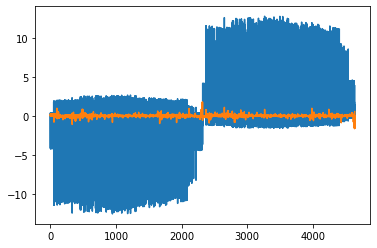

Reprojection Error after 2 images:1.1621
Reprojection Error after 3 images:2.1592
Reprojection Error after 4 images:10.6721
Reprojection Error after 5 images:3.5438
Reprojection Error after 6 images:1.7183
Reprojection Error after 7 images:77.3205
Reprojection Error after 8 images:2.8711
Reprojection Error after 9 images:9.9953
Reprojection Error after 10 images:4.1814
Reprojection Error after 11 images:6.3991
Reprojection Error after 12 images:6.3255
Reprojection Error after 13 images:12.9911
Reprojection Error after 14 images:2.2593
Reprojection Error after 15 images:10.1835
Reprojection Error after 16 images:3.5343
Reprojection Error after 17 images:29.7171
Reprojection Error after 18 images:6.3611
Reprojection Error after 19 images:7.6487
Reprojection Error after 20 images:5.6176
Reprojection Error after 21 images:8.3317
Reprojection Error after 22 images:3.5008
Reprojection Error after 23 images:12.0091
Reprojection Error after 24 images:6.2848
Reprojection Error after 25 images:3

In [16]:
bac = run_3d_reconstruction_sfm(calibrated=False, customized_ransac=False, cloud_filename='sparse_uncalibrated.ply')

In [17]:
visualization(cloud_filename='sparse_uncalibrated.ply')

[Open3D WARNING] Read PLY failed: unable to read file: sparse_uncalibrated.ply
Statistical oulier removal
Showing outliers (red) and inliers (gray): 


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3443e+10                                    3.13e+12    
       1              4         4.7593e+09      8.68e+09       9.48e+04       1.95e+11    
`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 1.3443e+10, final cost 4.7593e+09, first-order optimality 1.95e+11.
Optimization took 33 seconds


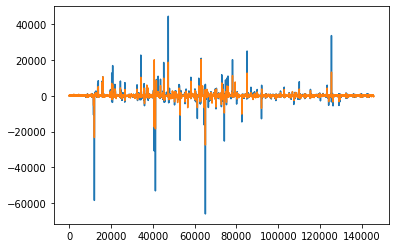

In [18]:
clouds = bundel_adjustemt_multiview(bac.clouds, bac.p_matrices, bac.key_points, bac.camera_indices, bac.point_indices)